In [1]:
!nvidia-smi

Fri Aug 28 10:32:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!git clone https://github.com/NVIDIA/apex /apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
models		    train-eval-sddEff.ipynb	trainval.zip
train-eval-2.ipynb  train-eval-sddLite.ipynb
train-eval.ipynb    train_eval_sddLiteV2.ipynb


In [3]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d /content
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp -r single-shot-detection-pytorch/. .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 325 (delta 133), reused 246 (delta 62), pack-reused 0
Receiving objects: 100% (325/325), 8.58 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (133/133), done.
     |████████████████████████████████| 122kB 9.0MB/s 
     |████████████████████████████████| 952kB 13.3MB/s 


In [4]:
import os
import time
import torch
import torch.cuda as cuda
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from dataset import VOCDataset, collate_fn
from ssd300 import SSD300
from loss import MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint
from eval_detection_voc import eval_detection_voc
device = torch.device("cuda" if cuda.is_available() else "cpu") 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')

In [ ]:
!ls datasets/

label_map.json	   TRAIN_objects.json  VAL_objects.json  VOC2012
TRAIN_images.json  VAL_images.json     VOC2007


In [5]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True, img_size=300)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'), img_size=300)

dataloaders = dict(
    train = DataLoader(trainset, batch_size=32, collate_fn=collate_fn, shuffle=True, num_workers=2),
    val = DataLoader(valset, batch_size=32, collate_fn=collate_fn, shuffle=False, num_workers=2),
)

## EDA

In [ ]:
def visualize_objects_stat(dataset):
    targets = dataset.targets
    objects = list()
    for target in targets:
        objects.extend(target['labels'])
    print('Total number of annotated objects:', len(objects))
    sns.countplot(objects)

In [ ]:
label_map

{'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20,
 'background': 0}

Total number of annotated objects: 49949


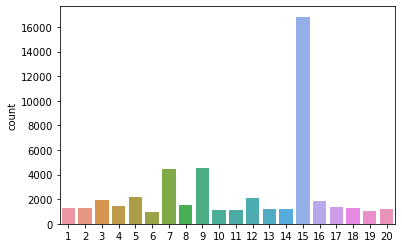

In [ ]:
visualize_objects_stat(trainset)

Total number of annotated objects: 12250


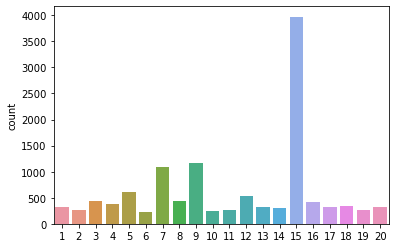

In [ ]:
visualize_objects_stat(valset)

## Train model

In [ ]:
# Load the model with pretrained weights
checkpoint_path = gdrive_dir+'models/checkpoint_ssd.pt'
checkpoint = torch.load(checkpoint_path)
ssd300 = checkpoint['model'].to(device)
ssd300.priors_cxcy = ssd.priors_cxcy.to(device)

ssd300.requires_grad_(False)
ssd300.det_conv4_3.requires_grad_(True)
ssd300.det_conv7.requires_grad_(True)
ssd300.det_conv8_2.requires_grad_(True)
ssd300.det_conv9_2.requires_grad_(True)
ssd300.det_conv10_2.requires_grad_(True)
ssd300.det_conv11_2.requires_grad_(True)

optimizer = torch.optim.SGD(ssd300.parameters(), lr=2e-3, momentum=0.9, weight_decay=5e-4)
loss_func = MultiBoxLoss(priors_cxcy=ssd300.get_prior_boxes(), threshold=0.5, alpha=1., neg_pos_ratio=3, focal_loss=False)

In [ ]:
# load the checkpoint from previous training time to continue training
checkpoint_path = gdrive_dir+'models/checkpoint_ssd.pt'
checkpoint = torch.load(checkpoint_path)

ssd = checkpoint['model']
optimizer = checkpoint['optimizer']

loss_func = MultiBoxLoss(priors_cxcy=ssd300.get_prior_boxes(), threshold=0.5, alpha=1., neg_pos_ratio=3, focal_loss=False)

In [12]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 50 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item():.4f}')
        
        train_loss += loss.item()
        
    return round(train_loss/len(trainset_loader), 4)

def eval_epoch(model, valset_loader, loss_func):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels) in enumerate(valset_loader):
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return round(val_loss/len(valset_loader), 4)


def train_model(model, dataloaders, optimizer, loss_func, lr_scheduler=None, n_epoch=1, checkpoint=None):
    last_epoch = 0
    if checkpoint:
        last_epoch = checkpoint['epoch']

    train_loss_hist, val_loss_hist = [], []
    for epoch_id in range(last_epoch+1, last_epoch+n_epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, epoch_id)
        training_time = round(time.time() - start_time)
        if lr_scheduler: lr_scheduler.step()
        
        save_checkpoint(epoch_id, model, optimizer, checkpoint_path)
        
        # eval val_loss every epoch
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func) # if epoch_id % 5 == 0 else 'N/A'
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {epoch_id} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss} - val_loss: {val_loss}')
        
    return train_loss_hist, val_loss_hist

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [19]:
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=3)

Epoch 1 - step 0: train_loss: 3.2854
Epoch 1 - step 50: train_loss: 3.2600
Epoch 1 - step 100: train_loss: 2.5960
Epoch 1 - step 150: train_loss: 2.4145
Epoch 1 - step 200: train_loss: 2.6016
Epoch 1 - step 250: train_loss: 2.3064
Epoch 1 - step 300: train_loss: 2.5987
Epoch 1 - step 350: train_loss: 2.2840
Epoch 1 - step 400: train_loss: 2.5457
Epoch 1 - step 450: train_loss: 2.5958
Epoch 1 - step 500: train_loss: 2.5335
Epoch 1 - train/val_time: 385s | 68s - train_loss: 2.6958 - val_loss: 2.8556
Epoch 2 - train/val_time: 388s | 67s - train_loss: 2.5308 - val_loss: 2.7458
Epoch 3 - train/val_time: 392s | 68s - train_loss: 2.4179 - val_loss: 2.6764


In [22]:
# Unfreeze extra conv blocks
ssd300.conv8_1.requires_grad_(True)
ssd300.conv8_2.requires_grad_(True)
ssd300.conv9_1.requires_grad_(True)
ssd300.conv9_2.requires_grad_(True)
ssd300.conv10_1.requires_grad_(True)
ssd300.conv10_2.requires_grad_(True)
ssd300.conv11_1.requires_grad_(True)
ssd300.conv11_2.requires_grad_(True)

adjust_learning_rate(optimizer, lr=1e-3)
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=3, checkpoint=checkpoint)

Epoch 4 - train/val_time: 395s | 68s - train_loss: 2.3362 - val_loss: 2.6411
Epoch 5 - train/val_time: 395s | 68s - train_loss: 2.3033 - val_loss: 2.6207
Epoch 6 - train/val_time: 395s | 68s - train_loss: 2.2588 - val_loss: 2.5918


In [25]:
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 7 - train/val_time: 393s | 68s - train_loss: 2.238 - val_loss: 2.5783
Epoch 8 - train/val_time: 392s | 68s - train_loss: 2.2125 - val_loss: 2.567
Epoch 9 - train/val_time: 392s | 68s - train_loss: 2.1883 - val_loss: 2.5437
Epoch 10 - train/val_time: 392s | 68s - train_loss: 2.1759 - val_loss: 2.5352
Epoch 11 - train/val_time: 393s | 68s - train_loss: 2.1582 - val_loss: 2.5235


In [28]:
# Unfreeze the whole net for final fine-tuning
ssd300.backbone.requires_grad_(True)

adjust_learning_rate(optimizer, lr=0.3e-3)
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=3, checkpoint=checkpoint)

Epoch 12 - train/val_time: 557s | 68s - train_loss: 2.0917 - val_loss: 2.4852
Epoch 13 - train/val_time: 563s | 70s - train_loss: 2.0384 - val_loss: 2.4636
Epoch 14 - train/val_time: 567s | 69s - train_loss: 2.0081 - val_loss: 2.4539


In [31]:
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 15 - train/val_time: 560s | 68s - train_loss: 1.9855 - val_loss: 2.4485
Epoch 16 - train/val_time: 564s | 69s - train_loss: 1.9747 - val_loss: 2.4471
Epoch 17 - train/val_time: 563s | 69s - train_loss: 1.9618 - val_loss: 2.4398
Epoch 18 - train/val_time: 565s | 69s - train_loss: 1.9506 - val_loss: 2.4375
Epoch 19 - train/val_time: 564s | 69s - train_loss: 1.9394 - val_loss: 2.4268


In [34]:
adjust_learning_rate(optimizer, lr=0.1e-3)
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=5, checkpoint=checkpoint)

Epoch 20 - train/val_time: 559s | 69s - train_loss: 1.9277 - val_loss: 2.4219
Epoch 21 - train/val_time: 565s | 69s - train_loss: 1.9182 - val_loss: 2.4161
Epoch 22 - train/val_time: 564s | 69s - train_loss: 1.911 - val_loss: 2.4192
Epoch 23 - train/val_time: 564s | 68s - train_loss: 1.904 - val_loss: 2.4202
Epoch 24 - train/val_time: 563s | 69s - train_loss: 1.9014 - val_loss: 2.4197


In [37]:
adjust_learning_rate(optimizer, lr=0.05e-3)
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=3, checkpoint=checkpoint)

Epoch 25 - train/val_time: 562s | 69s - train_loss: 1.8966 - val_loss: 2.4182
Epoch 26 - train/val_time: 565s | 69s - train_loss: 1.8987 - val_loss: 2.4149
Epoch 27 - train/val_time: 564s | 69s - train_loss: 1.8948 - val_loss: 2.416


In [40]:
adjust_learning_rate(optimizer, lr=0.03e-3)
train_hist, val_hist = train_model(ssd300, dataloaders, optimizer, loss_func, n_epoch=3, checkpoint=checkpoint)

Epoch 28 - train/val_time: 562s | 69s - train_loss: 1.888 - val_loss: 2.4157
Epoch 29 - train/val_time: 565s | 69s - train_loss: 1.89 - val_loss: 2.4163
Epoch 30 - train/val_time: 566s | 69s - train_loss: 1.8989 - val_loss: 2.4159


## Evaluate

In [14]:
def eval_APs_mAP(model, valset_loader):
    '''
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    
    with torch.no_grad():
        for step, (imgs, boxes, labels) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.post_process_top_k(predicted_offsets, predicted_scores,
                                                                                      score_threshold=0.02, iou_threshold=0.45, top_k=200)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)

        # calculate metrics value
        detected_boxes_np = [i.cpu().numpy() for i in detected_boxes]
        detected_labels_np = [i.cpu().numpy() for i in detected_labels]
        detected_scores_np = [i.cpu().numpy() for i in detected_scores]
        true_boxes_np = [i.cpu().numpy() for i in true_boxes]
        true_labels_np = [i.cpu().numpy() for i in true_labels]
        result = eval_detection_voc(detected_boxes_np, detected_labels_np, detected_scores_np, true_boxes_np, true_labels_np)
    
    return result['ap'], result['map']

In [43]:
APs, mAP = eval_APs_mAP(ssd300, dataloaders['val'])
print(np.around(APs, decimals=3))
print(np.around(mAP, decimals=4))

[  nan 0.816 0.834 0.741 0.675 0.452 0.824 0.842 0.925 0.603 0.76  0.705
 0.88  0.862 0.857 0.849 0.611 0.753 0.767 0.927 0.761]
0.7722
